## Dev Dashboarding ##
panel serve PHNX_prod_analytics.ipynb --session-token-expiration 600
* https://docs.google.com/document/d/1PU1OUlR6i1fGRnLsv8iYXmmY_byGu2kccWzCMyY922o/edit

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import panel as pn
import pickle
import numpy as np

repo_dir = os.path.dirname(os.getcwd())
if repo_dir not in sys.path: sys.path.append(repo_dir)
mod_dir = f'{os.path.dirname(os.path.dirname(repo_dir))}/analytics_utils/'
if mod_dir not in sys.path: sys.path.append(mod_dir)

from analysis_pipeline.analysis_pipeline import AnalysisPipeline
from analytics_utils.lims_tools.lims_utils import get_plate_runs, plates_from_exp, plates_from_workflow
from analytics_utils.database_access.s3_interface import download_from_s3, upload_to_s3, s3_imgupload, s3_df2csv, s3_csv2df
from analytics_utils.database_access.table_properties import * 
from analytics_utils.visualization_tools.visualization_utils import plot_boxplot
from analytics_utils.analysis_tools.dataset_creation_utils import combine_col_labels

pd.set_option('display.max_columns', None)
s3_model_bucket = 'ml-models-registry'
s3_model_bucket_subdirectory = 'exerevnetes-preprocessing-models/'

pn.extension(sizing_mode="stretch_width")
overall_analytics_panel = []
variant_analytics_panel = []
top_variant_reps = []
top_variant_analytics_panel = []
activity_corr_panel = []
activityCV_corr_panel = []
plate_analytics_panel = []
library_analytics_panel = []
unit_analytics_panel = []

# Get data from table

In [18]:
s3_subfolder = 'PHNX-100mM-Unit2to11/'  # 'PHNX-220mM-Unit12to18/'  # 
exp_workflow = ['WF10125','WF10128','WF10130','WF10132', 'WF10134', 'WF10136', 'WF10139', 'WF10141', 'WF10144', 'WF10149', 'WF10157'] # ['WF10158', 'WF10163', 'WF10169', 'WF10173', 'WF10181', 'WF10186', 'WF10188'] # 
table = 'combi_analytics_table' # 'lcms_detections' # 
# metric_dict = {'LcmsC18':['pellet_OD', 'measured_nonbinary_sum_(r)','measured_nonbinary_score_(r)', 'measured_conversion_(r)']}
metric_dict = {'LcmsC18':['measured_nonbinary_sum_(r)','measured_nonbinary_score_(r)', 'measured_conversion_(r)'], 'LcmsChiral':['measured_enantiomeric_excess_(+over-)']}

analysis_pipeline = AnalysisPipeline(
    s3_subfolder=s3_subfolder, 
    neg_ctrltype='EV', 
    sort_by=None, 
    metric_dict=metric_dict, 
    get_dashboard_panel=False,
    save_plots_to_s3=True,
    hit_filter_dict = {'measured_nonbinary_score_(r)': 5} # 0.2 (1mM) # 1.5 (100mM) # 5 (220mM)
)
df = analysis_pipeline.load_data(table, exp_workflow=exp_workflow)

if table == 'lcms_detections':
    df = analysis_pipeline.get_derived_metrics(df, derived_metrics_to_get=['LcmsC18'])
    df = analysis_pipeline.standardize_dataset_columns(df, data_type=table, update_analytics_table=update_analytics_table)

# save full table to S3
csv_fname = f'{table}_{"-".join(exp_workflow)}'
analysis_pipeline.save_content_to_s3(csv_fname, df, file_format='csv', content_header='FULL DATASET', content_type='dataframe')

executing query: SELECT "id", "exp_workflow_barcode", "exp_workflow_name", "proj_barcode", "proj_name", "maldi_run", "lcms_C18_run", "lcms_chiral_run", "maldi_plate_(r)", "maldi_address_(r)", "lcms_plate_(r)", "lcms_address_(r)", "source_plate_(r)", "source_address_(r)", "maldi_plate_(+)", "maldi_address_(+)", "lcms_plate_(+)", "lcms_address_(+)", "source_plate_(+)", "source_address_(+)", "maldi_plate_(-)", "maldi_address_(-)", "lcms_plate_(-)", "lcms_address_(-)", "source_plate_(-)", "source_address_(-)", "ctrl_type", "exp_condition", "enzyme_barcode", "sequence", "mutations", "hamming", "reference_enzyme", "substrate_barcode_(r)", "substrate_barcode_(+)", "substrate_barcode_(-)", "substrate_smiles_(r)", "substrate_smiles_(+)", "substrate_smiles_(-)", "substrate_concentration_(r)", "substrate_concentration_(+)", "substrate_concentration_(-)", "predicted_binary_score_(r)", "predicted_nonbinary_score_(r)", "measured_nonbinary_score_(r)", "measured_nonbinary_sum_(r)", "measured_conversio

# Clean up dataset

In [19]:
add_workflow_to_plate_labels = True 

if add_workflow_to_plate_labels:
    df = combine_col_labels(df, new_col_name='workflow_plate', cols_to_combine=['exp_workflow_barcode', 'lcms_plate_(r)'])

In [12]:
# filter to keep only desired substrate concentrations
df = df.loc[(df['substrate_concentration_(r)']>300)]

In [20]:
# relabel Unit 6 controls
df.loc[(df.exp_workflow_barcode=='WF10132') & (df.ctrl_type=='EV') & (df['measured_nonbinary_score_(r)']>1.5), 'ctrl_type'] = 'pos'
df.loc[(df.exp_workflow_barcode=='WF10132') & (df.ctrl_type=='pos') & (df['measured_nonbinary_score_(r)']<0.9), 'ctrl_type'] = 'EV'

# Get Overall Analytics

In [ ]:
overall_analytics, overall_analytics_panel = analysis_pipeline.GET_OVERALL_ANALYTICS(df, groupby=['ctrl_type'], display_table=True, plot_scatterplot=True, plot_histogram=True, calc_FIOP_bygrp=False, get_ctrls_from_vals=False)

# Get Variant Analytics

In [ ]:
# get experiment analytics metrics
variant_analytics, variant_analytics_panel = analysis_pipeline.GET_VARIANT_ANALYTICS(df, display_table=True)

### get individual boxplots for each variant

In [ ]:
# # get boxplots, split by substrate concentration, with all variants
# for sub_conc in set(top_variant_reps['substrate_concentration_(r)']):
#     top_variant_reps_subconc = top_variant_reps.loc[top_variant_reps['substrate_concentration_(r)']==sub_conc]
#     boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(top_variant_reps_subconc, metric_list=['measured_nonbinary_score_(r)', 'pellet_OD', 'measured_nonbinary_sum_(r)'], metricname_list=['RacemicProduct', 'PelletOD', 'RacemicSum'], groupby=['mutations', 'exp_condition'])

# get boxplots, split by enzyme variant
enz_list = top_variant_stats.mutations.tolist()
for enz in enz_list:
    variant_reps = df.loc[df['mutations']==enz]
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(variant_reps, metric_list=['measured_nonbinary_score_(r)'], metricname_list=['RacemicProduct'], groupby=['mutations', 'exp_condition'])


In [ ]:
plot_activity_corr_list = analysis_pipeline.get_activity_correlation_plots(top_variant_reps, xmetric_list=['pellet_OD', 'measured_nonbinary_sum_(r)'], xmetricname_list=['PelletOD', 'RacemicSum'], ymetric='measured_nonbinary_score_(r)', ymetricname='RacemicProduct', groupby='mutations')
plot_activityCV_corr_list = analysis_pipeline.get_activity_CV_correlation_plots(top_variant_stats, xmetric_list=['pellet_OD_cv', 'measured_nonbinary_sum_(r)_cv'], xmetricname_list=['PelletOD-CV', 'RacemicSum-CV'], ymetric='measured_nonbinary_score_(r)_cv', ymetricname='RacemicProduct-CV', groupby='mutations')
activity_corr_panel = pn.Column(
    '# Correlation of PelletOD & SumConc to Activity (by sample)', 
    *plot_activity_corr_list[:3], 
    pn.Row(*plot_activity_corr_list[3:], background='White'), 
    background='White', width=1500, scroll=True)
activityCV_corr_panel = pn.Column(
    '# Correlation of CV of PelletOD & SumConc to CV of Activity (by variant)', 
    pn.Row(*plot_activityCV_corr_list), 
    background='White', scroll=True)

# Get Plate Analytics

****************************
Computing Plate Analytics...
****************************
LcmsC18 ['measured_nonbinary_sum_(r)', 'measured_nonbinary_score_(r)', 'measured_conversion_(r)']
Saved PHNX-100mM-Unit2to11/BOXPLOT_measured_nonbinary_sum_(r)_lcms_plate_(r).png to S3.
Saved PHNX-100mM-Unit2to11/BOXPLOT_measured_nonbinary_score_(r)_lcms_plate_(r).png to S3.
Saved PHNX-100mM-Unit2to11/BOXPLOT_measured_conversion_(r)_lcms_plate_(r).png to S3.
LcmsChiral ['measured_enantiomeric_excess_(+over-)']
Saved PHNX-100mM-Unit2to11/BOXPLOT_measured_enantiomeric_excess_(+over-)_lcms_plate_(r).png to S3.


,lcms_plate_(r),exp_workflow_barcode,substrate_concentration_(r),n_var,n_LcmsC18,n_LcmsChiral,measured_nonbinary_sum_(r)_mean_EV,measured_nonbinary_sum_(r)_cv_EV,measured_nonbinary_sum_(r)_mean_POS,measured_nonbinary_sum_(r)_cv_POS,measured_nonbinary_sum_(r)_max_FIOP,measured_nonbinary_sum_(r)_median_FIOP,measured_nonbinary_sum_(r)_mean,measured_nonbinary_sum_(r)_cv,measured_nonbinary_score_(r)_mean_EV,measured_nonbinary_score_(r)_cv_EV,measured_nonbinary_score_(r)_mean_POS,measured_nonbinary_score_(r)_cv_POS,measured_nonbinary_score_(r)_max_FIOP,measured_nonbinary_score_(r)_median_FIOP,measured_nonbinary_score_(r)_mean,measured_nonbinary_score_(r)_cv,measured_nonbinary_score_(r)_nonhitrate,measured_conversion_(r)_mean_EV,measured_conversion_(r)_cv_EV,measured_conversion_(r)_mean_POS,measured_conversion_(r)_cv_POS,measured_conversion_(r)_max_FIOP,measured_conversion_(r)_median_FIOP,measured_conversion_(r)_mean,measured_conversion_(r)_cv,measured_enantiomeric_excess_(+over-)_mean_EV,measured_enantiomeric_excess_(+over-)_cv_EV,measured_enantiomeric_excess_(+over-)_mean_POS,measured_enantiomeric_excess_(+over-)_cv_POS,measured_enantiomeric_excess_(+over-)_max_FIOP,measured_enantiomeric_excess_(+over-)_median_FIOP,measured_enantiomeric_excess_(+over-)_mean,measured_enantiomeric_excess_(+over-)_cv
all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,NaN,445.000,397.000,NaN,NaN,NaN,NaN,NaN,NaN,109.837,0.115,NaN,NaN,NaN,NaN,NaN,NaN,0.856,0.615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008,0.595,NaN,NaN,NaN,NaN,NaN,NaN,-0.009,-7.124
all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,NaN,295.000,197.000,NaN,NaN,NaN,NaN,NaN,NaN,101.490,0.128,NaN,NaN,NaN,NaN,NaN,NaN,3.608,0.495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036,0.490,NaN,NaN,NaN,NaN,NaN,NaN,0.003,24.954
all exp ctrls (by lcms_plate_(r)),NaN,NaN,140.000,158.829,290.886,59.686,103.670,0.068,101.803,0.044,1.439,1.036,102.095,0.079,0.577,0.092,3.629,0.233,8.493,0.279,2.879,0.149,0.893,0.005,0.100,0.036,0.228,8.153,0.284,0.028,0.083,-0.019,-1.069,-0.002,0.124,21.596,-0.399,0.001,0.741
0,PLT17286,WF10125,140.000,199.000,352.000,4.000,100.872,0.020,101.139,0.096,1.538,1.019,100.365,0.072,-0.226,-0.064,3.097,0.129,1.870,-0.065,-0.134,-4.456,0.997,-0.002,-0.064,0.031,0.129,1.870,-0.065,-0.001,-4.456,0.007,1.278,0.062,0.148,10.375,3.607,0.033,1.095
1,PLT17289,WF10125,140.000,232.000,344.000,0.000,75.180,0.668,107.719,0.049,4.875,1.128,109.011,0.236,-0.174,-0.668,5.043,0.103,0.895,-0.058,-0.190,-1.396,1.000,-0.002,-0.668,0.050,0.103,0.896,-0.058,-0.002,-1.423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PLT17292,WF10125,140.000,217.000,352.000,10.000,112.629,0.132,118.014,0.048,1.466,1.251,120.677,0.105,-0.223,-0.146,1.868,0.592,11.030,-0.056,-0.080,-27.022,0.997,-0.002,-0.146,0.017,0.592,10.026,-0.050,-0.001,-27.022,0.037,0.048,0.040,0.184,14.462,6.952,0.056,0.422
3,PLT17294,WF10125,140.000,179.000,351.000,5.000,91.656,0.053,85.454,0.028,1.228,0.890,88.131,0.064,-0.254,-0.087,2.307,0.484,6.156,-0.074,-0.134,-9.952,0.994,-0.003,-0.087,0.026,0.484,6.868,-0.082,-0.001,-9.952,0.027,0.031,0.034,0.355,5.259,4.907,0.037,0.128
4,PLT17352,WF10128,140.000,173.000,352.000,0.000,93.170,0.036,87.089,0.051,1.011,0.910,90.106,0.044,0.311,0.025,3.943,0.084,2.858,0.085,0.458,1.663,0.991,0.003,0.025,0.043,0.084,3.108,0.092,0.005,1.663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PLT17355,WF10128,140.000,57.000,346.000,0.000,83.451,0.040,83.248,0.022,0.970,0.848,84.014,0.065,0.285,0.018,3.345,0.112,4.926,0.080,0.862,2.736,0.980,0.003,0.018,0.040,0.112,5.960,0.097,0.011,2.727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PLT17358,WF10130,140.000,249.000,352.000,0.000,96.982,0.062,94.980,0.035,1.102,0.995,98.355,0.037,0.537,0.016,1.900,0.288,3.896,0.148,0.671,1.391,0.991,0.006,0.016,0.020,0.288,4.130,0.157,0.007,1.391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved PHNX-100mM-Unit2to11/plate_METRICS.csv to S3.
Obtained plate analytics metrics. 



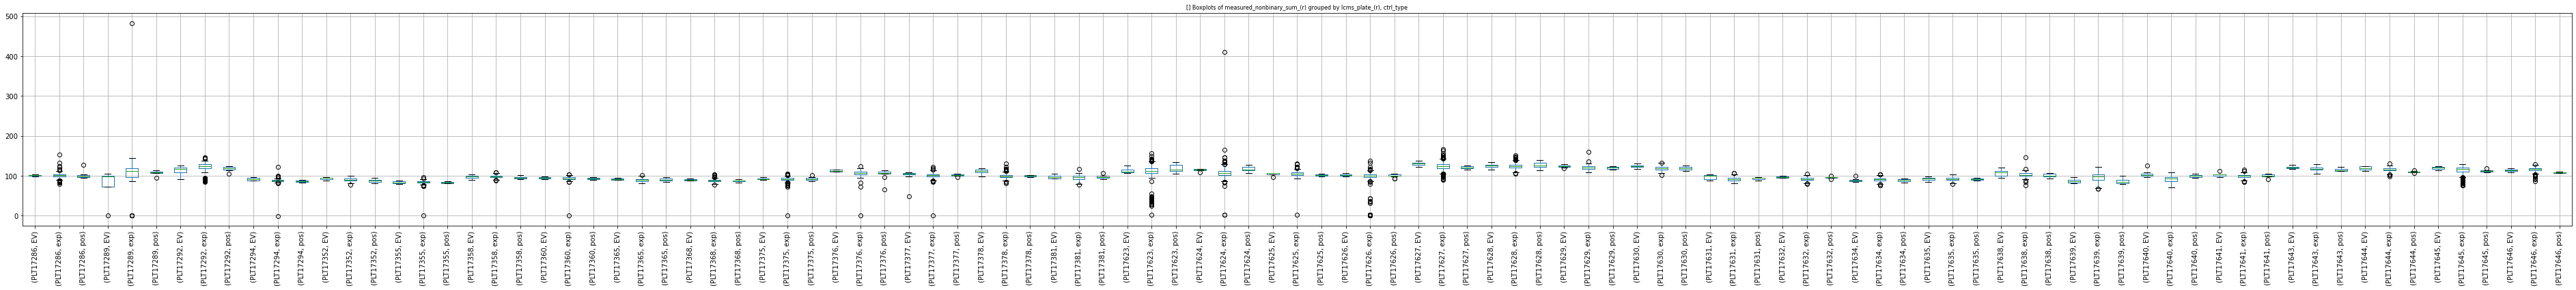

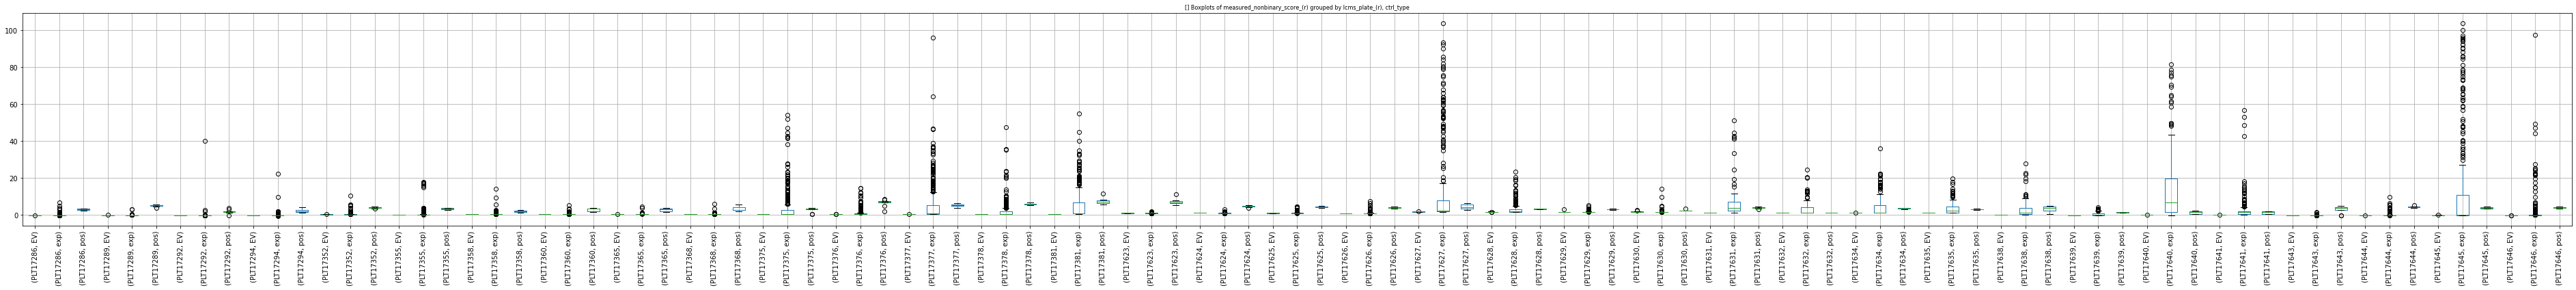

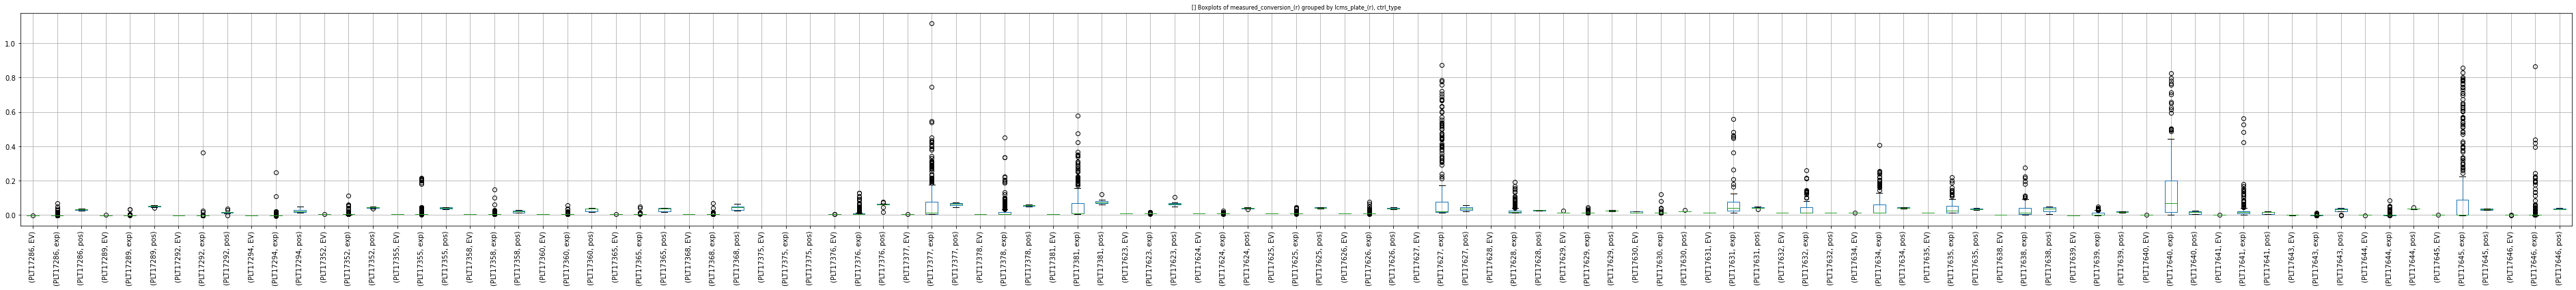

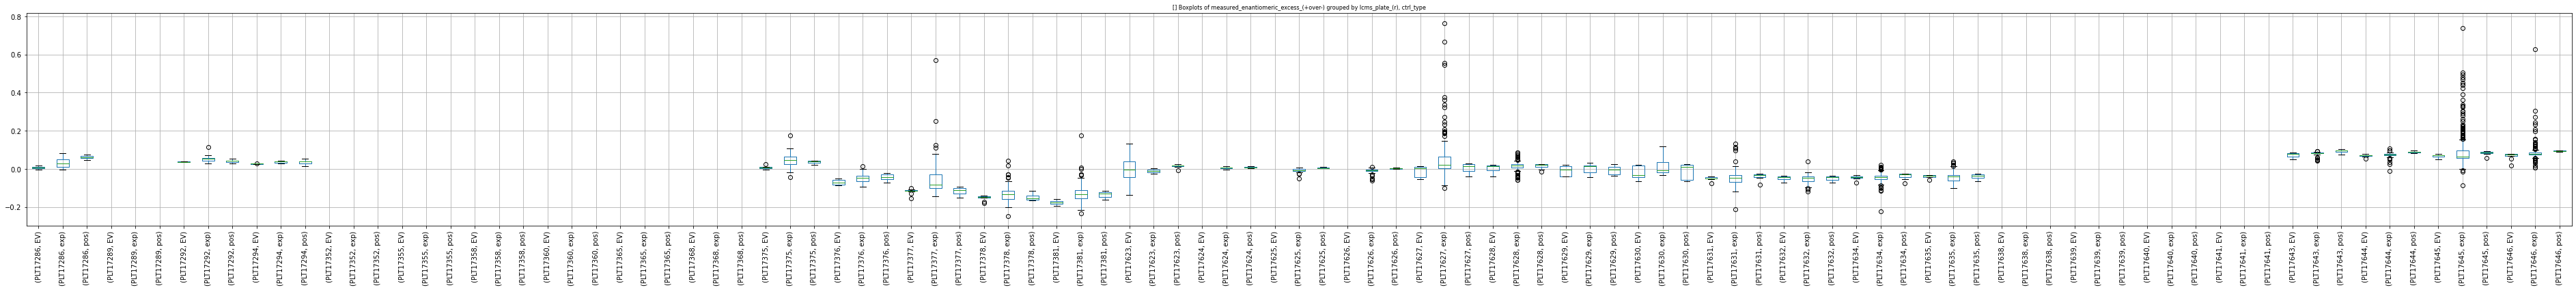

In [21]:
plate_analytics, plate_analytics_panel = analysis_pipeline.GET_PLATE_ANALYTICS(df, display_table=True, groupby=['lcms_plate_(r)', 'exp_workflow_barcode', 'substrate_concentration_(r)'], plot_scatterplot=False, plot_histogram=False, calc_FIOP_bygrp=False, get_ctrls_from_vals=False)

## Plate analytics for positive controls only

Saved PHNX-100mM-Unit2to11/BOXPLOT_POS-ONLY_RacemicProduct_workflow_plate.png to S3.
Saved PHNX-100mM-Unit2to11/BOXPLOT_POS-ONLY_RacemicSum_workflow_plate.png to S3.


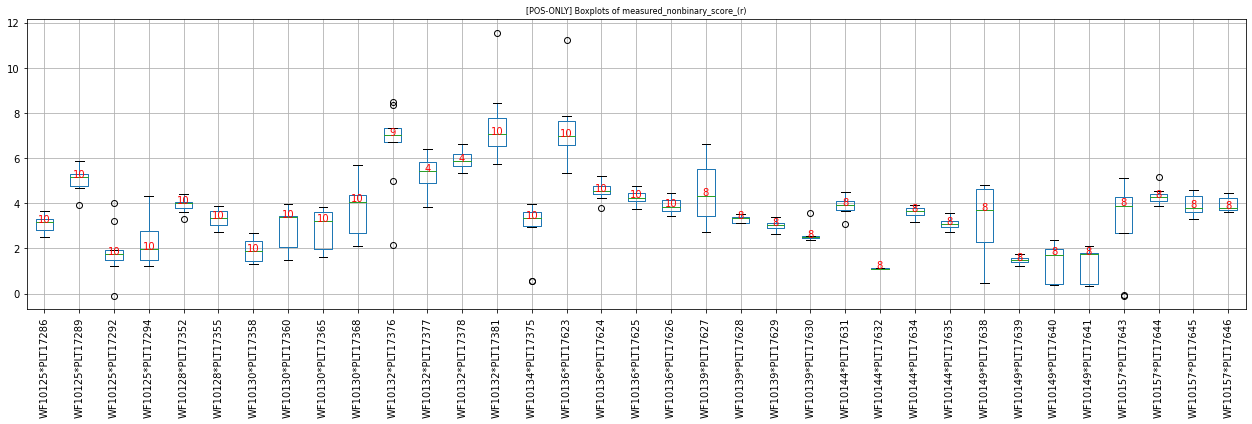

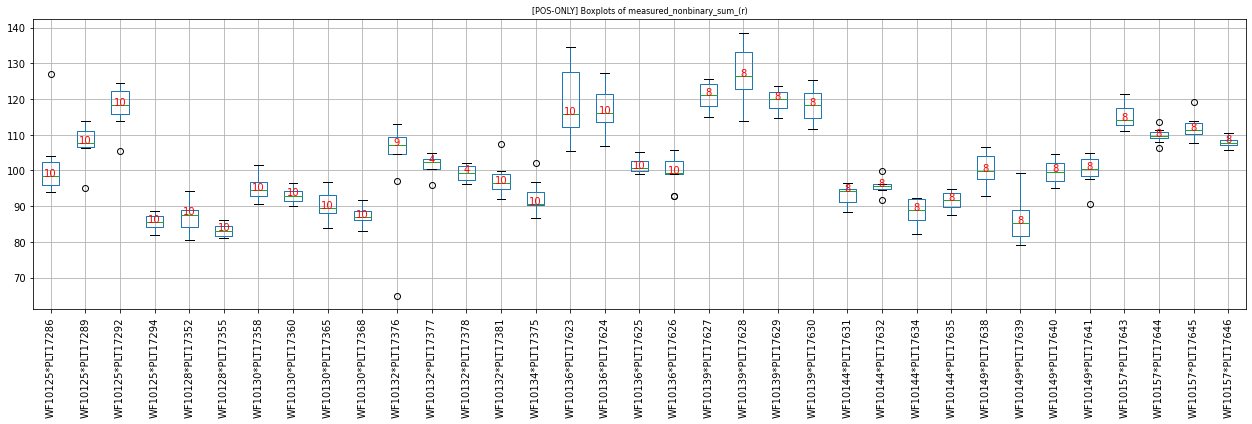

In [23]:
# get positive controls onlh
df_pos = df[df.ctrl_type=='pos'].copy().sort_values(by='workflow_plate')

# plot boxplots
metric_list=['measured_nonbinary_score_(r)', 'measured_nonbinary_sum_(r)']
metricname_list=['RacemicProduct', 'RacemicSum']

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):

    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        df_pos, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['workflow_plate'],
        fname_prefix='POS-ONLY_',
    )

# Get Analytics Dashboard

In [ ]:
analytics_panel = overall_analytics_panel + variant_analytics_panel + top_variant_analytics_panel + top_variant_analytics_panel + activity_corr_panel + activityCV_corr_panel + plate_analytics_panel + library_analytics_panel + unit_analytics_panel

pn.template.FastListTemplate(
    site="Panel", 
    title="PHNX Production Analytics", 
    main=analytics_panel, 
    main_max_width="1760px",
).servable();

# Manual Analysis

In [ ]:
lib = 'LIB13047'
df_LIB = df[df.library_barcode==lib]
enz_list = list(set(df_LIB.mutations))

col_to_plot = 'measured_nonbinary_score_(r)'
groupby = ['substrate_concentration_(r)', 'exp_condition']
for enz in enz_list:
    df_enz = df_LIB.loc[df_LIB.mutations==enz]
    exp_condition_list = list(set(df_enz.exp_condition))
    print(enz, exp_condition_list)
    mut = df_enz.iloc[0]['mutations']
    n = len(df_enz)
    ax = df_enz.boxplot(column=col_to_plot, by=groupby, rot=90, figsize=(6,6))
    ax_labels = [label._text[1:-1].split(', ') for label in ax.get_xticklabels()]
    for tick, label in enumerate(ax_labels):
        df_label = df_enz.loc[(df_enz[groupby[0]]==float(label[0])) & (df_enz[groupby[1]]==label[1])]
        n_label = len(df_label)
        ax.text(tick+1, df_label[col_to_plot].median(), n_label, horizontalalignment='center', color='r')
    plt.title(f'{enz} ({mut}), n={n}')
    plt.show()

# Comparison with historical Phoenix data

### Get old data

In [44]:
exp_workflow_phnx = ['WF10125','WF10128','WF10130','WF10132', 'WF10134', 'WF10136', 'WF10139', 'WF10144', 'WF10149', 'WF10157', 'WF10158', 'WF10163', 'WF10169', 'WF10173', 'WF10181']  # None # 
df_phnx = analysis_pipeline.load_data(table, exp_workflow=exp_workflow_phnx)
# df_phnx = analysis_pipeline.get_derived_metrics(df_phnx, derived_metrics_to_get=['LcmsC18'])
df_phnx = analysis_pipeline.standardize_dataset_columns(df_phnx, data_type=table, update_analytics_table=False)

executing query: SELECT "id", "address", "run", "plate", "dev_or_prod", "exp_workflow_barcode", "exp_workflow_name", "proj_barcode", "proj_name", "ctrl_type", "exp_condition", "enzyme_barcode", "sequence", "hamming", "mutations", "reference_enzyme", "enzyme_concentration", "enzyme_unit", "enzyme_class", "sequence_qc", "sample_position", "sample_type", "substrate_barcode", "substrate_concentration", "substrate_unit", "substrate_smiles", "substrate_mz", "product_smiles", "product_mz", "sub_area", "prod_area", "ptr_lcms", "sub_conc_lcms_actual", "prod_conc_lcms_actual", "sum_conc_lcms_actual", "dilution_factor", "injector_volume", "expected_concentration", "concentration_units", "source_plate", "source_address", "seed_address", "seed_address_alphanumeric", "seed_plate", "main_plate", "rxn_plate", "library_barcode", "library_ref", "library_description", "seed_plate_time", "main_plate_time", "rxn_plate_time", "plate_time", "pellet_OD", "pellet_detected", "pellet_area", "pellet_intensity", "

### Filter for data slice

In [ ]:
# var_mutation = 'A129S' # 'V152A_L403T'
enz_barcode = 'ENZ10045'

# get variant data from phoenix     
# df_phnx_var = df_phnx[df_phnx.enzyme_barcode==enz_barcode].copy()
df_phnx_var = df_phnx[(df_phnx.enzyme_barcode==enz_barcode) & (df_phnx.ctrl_type=='pos')].copy()
# df_phnx_var = df_phnx[df_phnx.mutations==var_mutation].copy()
df_phnx_var = df_phnx_var[df_phnx_var.exp_workflow_barcode != 'WF10181'] # remove unit 16
df_phnx_var.loc[df_phnx_var['substrate_concentration_(r)']>300, 'substrate_concentration_(r)'] = 308
df_phnx_var.loc[:,'exp_condition'] = 'C41_PHNX'
display(df_phnx_var[['mutations', 'library_barcode', 'exp_condition']])

# get variant data from BL21 vs C41 experiment
df_var = df[(df.enzyme_barcode==enz_barcode) & (df.library_barcode=='LIB13036')].copy()
# df_var = df[df.mutations==var_mutation].copy()
display(df_var[['mutations', 'library_barcode', 'exp_condition']])

### Visualize analytics

In [ ]:
data_var = pd.concat([df_phnx_var, df_var])
col_to_plot = ['measured_nonbinary_score_(r)']
groupby = ['substrate_concentration_(r)', 'exp_condition', 'library_barcode', 'exp_workflow_barcode']
# groupby = ['substrate_concentration_(r)', 'exp_condition', 'exp_workflow_barcode']
boxplot_list = plot_boxplot(data_var, col_to_plot, groupby=groupby, showplot=True, show_n=True)